# Regression Proyect

The objective of this project is to practice regression techniques that you have learned in this class.  
To goal is to develop a machine learning model that can accurately predict the price of Airbnb properties in the San Francisco Bay Area.
Using the a few of the following models:
- Linear regression (including polynomial and regularized regression)  
- K-nearest neightbors  
- Decision trees  
- Support vector machines 

### Load Packages

In [1]:
import ast
import re
# from collections import Counter, defaultdict
import numpy as np 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer

### Load the Data

In [2]:
# Read the file
df = pd.read_csv('train.csv')

### EDA

In [4]:
# Overview of Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15274 entries, 0 to 15273
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           15274 non-null  object 
 1   price                        15274 non-null  float64
 2   name                         15274 non-null  object 
 3   neighborhood_overview        9910 non-null   object 
 4   host_id                      15274 non-null  int64  
 5   host_since                   15273 non-null  object 
 6   host_location                12239 non-null  object 
 7   host_about                   9285 non-null   object 
 8   host_response_time           12870 non-null  object 
 9   host_response_rate           12870 non-null  object 
 10  host_acceptance_rate         13640 non-null  object 
 11  host_is_superhost            15171 non-null  object 
 12  host_listings_count          15273 non-null  float64
 13  host_verificatio

We have too many columns. Select columns based on what you think will have an impact in predicting price. Remove the other columns from df.  
We also know we have missing information. We will take care of those later.

In [3]:
# Remove unnecessary columns
df.columns
remove_cols = ['Id', 'name', 'neighborhood_overview', 'host_about']
new_df = df.drop(columns=remove_cols)

need_clean = ['host_since', 'host_location', 'host_response_rate', 'host_acceptance_rate', 'host_verifications',
              'bathrooms_text', 'amenities', 'first_review', 'last_review']

In [20]:
def compute_weights(epsilon, d, p=2):
    return np.power(epsilon-d, p)/np.power(epsilon, p)

R = 6371

def haversine(x0, y0, x_vector, y_vector):
    x = np.deg2rad(x0)
    y = np.deg2rad(y0)
    lat = np.deg2rad(x_vector)
    long = np.deg2rad(y_vector)
    xdiff = x-lat
    ydiff = y-long
    
    d = np.sin(xdiff / 2)**2 + np.cos(x) * np.cos(lat) * np.sin(ydiff / 2)**2
    c = 2 * np.arctan2(np.sqrt(d), np.sqrt(1-d))
    km = R*c

    return km

In [3]:
# Clean my data

def data_pipeline(input_df, base=df):
    # Extract most importnant amenities from amenitites column
    # Create columns for the most important amenities
    important_amenities = ['oven', 'hair dryer', 'dishes and silverware', 'bathtub', 'stove', 'hot tub', 'dedicated workspace', 'hdtv', 'luggage dropoff', 'smoke detector', 'carbon monoxide',
     'fire extinguisher', 'cleaning products', 'balcony', 'patio', 'roomdarkening shades', 'shampoo', 'shower gel', 'private entrance', 'wifi', 'lock on bedroom door', 'refrigerator', 'washer',
     'security cameras', 'conditioner', 'wine glasses', 'hot water', 'pool', 'dryer', 'dishwasher', 'elevator', 'coffee maker', 'free street parking', 'smoke alarm', 'toaster', 'bed linens', 'cooking basics',
     'hot water kettle', 'self checkin', 'keypad', 'kitchen', 'tv', 'gym', 'dining table', 'laptopfriendly workspace', 'iron', 'carbon monoxide alarm', 'essentials', 'heating', 'first aid kit',
     'free breakfast', 'host greets you', 'long term stays allowed', 'freezer', 'coffee', 'laundromat nearby', 'outdoor', 'free parking', 'body soap', 'air conditioning', 'hangers', 'extra pillows and blankets',
     'smoking allowed', 'familyfriendly amenities', 'microwave', 'flexible cancellation', 'pet friendly']

    for amenity in important_amenities:
        input_df[amenity] = False

    input_df['amenities'] = input_df['amenities'].str.replace(r'\" ', 'in ').replace('-', '')
    input_df['amenities'] = input_df['amenities'].str.replace('-', '')
    
    # neighborhood_prices = []
    # epsilon = 1
    
    for i, row in input_df.iterrows():
        
        # Amenities dummy Variables
        amenities_list = row['amenities']
        for amenity in important_amenities:
            input_df.at[i, amenity] = amenity in amenities_list.lower()

    #     #Spatial dependency
    #     x0 = row["latitude"]
    #     y0 = row["longitude"]
        
    #     d = haversine(x0, y0, base["latitude"].values, base["longitude"].values)

    #     indices = np.where(d <= epsilon)[0]
    #     neighborhood = indices[indices != i]

    #     i_type = input_df.iloc[i]["property_type"]
    #     same_types = np.where(base["property_type"].values == i_type)[0]

    #     neighborhood = np.intersect1d(same_types, neighborhood)

    #     weights = compute_weights(epsilon, d[neighborhood])
    #     if len(weights) != 0:
    #         neighborhood_price = sum(base.iloc[neighborhood]["price"]*weights)/sum(weights)
    #     else:
    #         neighborhood_price = None

    #     neighborhood_prices.append(neighborhood_price)

    # input_df["neighborhood_price"] = neighborhood_prices

    return (input_df
        # Create year columns and remove date columns
        .assign(host_since=pd.to_datetime(input_df['host_since']).dt.year,
                first_review=pd.to_datetime(input_df['first_review']).dt.year,
                last_review=pd.to_datetime(input_df['last_review']).dt.year)

        # Extract city and State and remove host_location variable
        .assign(city=input_df['host_location'].str.split(', ', expand=True)[0],
                state=input_df['host_location'].str.split(', ', expand=True)[1])
        .drop(columns=['host_location'])

        # Convert text percentages into decimals
        .assign(host_response_rate=pd.to_numeric(input_df['host_response_rate'].str.strip('%')) / 100,
                host_acceptance_rate=pd.to_numeric(input_df['host_acceptance_rate'].str.strip('%')) / 100)

        # Convert list of verifications to number of verifications
        .assign(host_verifications=input_df['host_verifications'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else []).apply(len))

        # Extract bathroom and bathroom type from bathroom column
        .assign(bathrooms=input_df['bathrooms_text'].str.extract('(\d*\.?\d+)').astype(float).fillna(0),
                bathroom_type=input_df['bathrooms_text'].apply(lambda x: re.sub(r'[\d.]+', '', str(x)).strip())
                                                    .apply(lambda x: 'shared' if 'shared' in x
                                                                   else 'private' if 'private' in x
                                                                   else 'half-bath' if '-' in x
                                                                   else 'regular'))
        .drop(columns=['bathrooms_text'])

        # Convert amenities into a new column that has the number of amenitites in the place
        .assign(amenities=input_df['amenities'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else []).apply(len))

    )
new_df = data_pipeline(df)

In [ ]:
# # Get a set of all unique amenities in the dataset that are the most common
# new_df['amenities'] = new_df['amenities'].str.replace(r'\" ', 'in ').replace('-', '')
# new_df['amenities'] = new_df['amenities'].str.replace('-', '')
# new_df['amenities'] = new_df['amenities'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
# unique_amenities = set(amenity for amenities_list in new_df['amenities'] for amenity in amenities_list)
# unique_amenities
# amenity_counts = defaultdict(int)
# for amenities_list in new_df['amenities']:
#     for amenity in amenities_list:
#         amenity_counts[amenity.lower()] += 1
# amenity_counts = Counter(amenity for amenities_list in new_df['amenities'] for amenity in amenities_list)
# amts_df = pd.DataFrame(list(amenity_counts.items()), columns=['Amenity', 'Count'])
# amts_df = amts_df.sort_values(by='Count', ascending=False).head(50)
# new_amts = list(amts_df['Amenity'])
# new_amts = [amenity.lower() for amenity in new_amts]
# new_amts

Check for Multicolinearity

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_df = new_df.select_dtypes(include=['float64', 'int64']) # select numeric columns
predictors = numeric_df.drop(['price'], axis=1) # remove target variable
predictors = predictors.fillna(predictors.mean()) # Fill in NA with mean values
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])] # Get inflation Factors
vars_multicolinearity = list(vif_data[vif_data['VIF'] > 10]['Variable']) # identify columns that might be correlated
vif_data[vif_data['VIF'] > 10]

,Variable,VIF
15,maximum_minimum_nights,306.217394
16,minimum_maximum_nights,155.242905
17,maximum_maximum_nights,34.091429
18,minimum_nights_avg_ntm,333.899373
19,maximum_nights_avg_ntm,258.042374
20,availability_30,11.012787
21,availability_60,52.437601
22,availability_90,29.931232


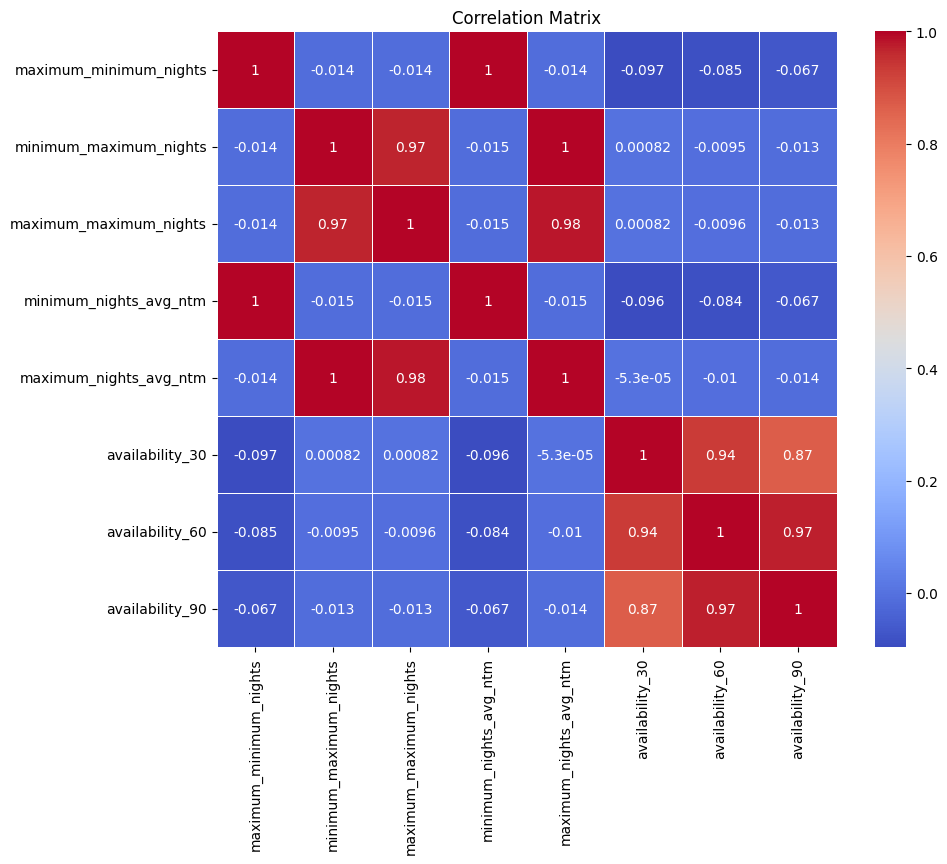

In [9]:
# Check for multicolinearity
import seaborn as sns
import matplotlib.pyplot as plt

# Select variables that might have multicorrelation
multi_df = new_df[vars_multicolinearity]

# Calculate the correlation matrix
correlation_matrix = multi_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Based on the Correlation matrix graph, we are going to remove the following columns:
- availability_30
- availability_90
- maximum_maximum_nights
- minimum_nights_avg_ntm
- maximum_nights_avg_ntm

In [4]:
new_df = new_df.drop(['availability_30', 'availability_90','maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1)

More feature engineer ideas:
- Do EDA do see if I need to trasnform my data
- Log transformations for some variables or 2nd degree poly

### Prepare the data

In [5]:
# Get your X with numeric features
X = new_df.drop(columns=['price'])
# Get you y
y = new_df['price']
# Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307, train_size=0.75)

# Numeric features and categorical features
numeric_features = ['host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'host_verifications',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights',
       'availability_60', 'availability_365','number_of_reviews', 'number_of_reviews_ltm', 
       'number_of_reviews_l30d','first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'bathrooms']
categorical_features = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'has_availability', 'instant_bookable', 'city', 'state',
       'bathroom_type', 'oven', 'hair dryer', 'dishes and silverware', 'bathtub', 'stove', 'hot tub', 'dedicated workspace', 
       'hdtv', 'luggage dropoff', 'smoke detector', 'carbon monoxide',
       'fire extinguisher', 'cleaning products', 'balcony', 'patio', 'roomdarkening shades', 'shampoo', 'shower gel', 
       'private entrance', 'wifi', 'lock on bedroom door', 'refrigerator', 'washer',
       'security cameras', 'conditioner', 'wine glasses', 'hot water', 'pool', 'dryer', 'dishwasher', 'elevator', 
       'coffee maker', 'free street parking', 'smoke alarm', 'toaster', 'bed linens', 'cooking basics',
       'hot water kettle', 'self checkin', 'keypad', 'kitchen', 'tv', 'gym', 'dining table', 'laptopfriendly workspace', 
       'iron', 'carbon monoxide alarm', 'essentials', 'heating', 'first aid kit',
       'free breakfast', 'host greets you', 'long term stays allowed', 'freezer', 'coffee', 'laundromat nearby',
       'outdoor', 'free parking', 'body soap', 'air conditioning', 'hangers', 'extra pillows and blankets',
       'smoking allowed', 'familyfriendly amenities', 'microwave', 'flexible cancellation', 'pet friendly']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handle missing data
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing data
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('select_percentile', SelectPercentile(score_func=f_regression, percentile=50))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### KNN

Do 10 fold cross validation to check for the following parameters:
- Polinomial Features
- Number of Neighbors
- Weights method

In [6]:
scoring_metric = 'neg_mean_absolute_error'

In [7]:
# Add the KNeighborsRegressor model to the pipeline
knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(weights='distance')) # Proximity may make a big difference in some of our features thereofre use 'distance'
])

# Define the parameter grid
params = {
    'model__n_neighbors': (2, 3, 4)
}

# Instantiate GridSearchCV
gs1 = GridSearchCV(knn_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)
gs1.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END ...............................model__n_neighbors=2; total time=   6.9s
[CV] END ...............................model__n_neighbors=2; total time=   6.2s
[CV] END ...............................model__n_neighbors=2; total time=   6.2s
[CV] END ...............................model__n_neighbors=2; total time=   6.0s
[CV] END ...............................model__n_neighbors=3; total time=   6.0s
[CV] END ...............................model__n_neighbors=3; total time=   6.5s
[CV] END ...............................model__n_neighbors=3; total time=   7.7s
[CV] END ...............................model__n_neighbors=3; total time=   7.1s
[CV] END ...............................model__n_neighbors=4; total time=   5.7s
[CV] END ...............................model__n_neighbors=4; total time=   6.0s
[CV] END ...............................model__n_neighbors=4; total time=   6.2s
[CV] END ...............................model__n_

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_id',
                                                                          'host_since',
                                                                          'host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_listings_count',
                                                                          'host_verifications',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'amenities...
                                                                          'hot '
                                                                          'tub',
                                                                          'dedicated '
                                                                          'workspace',
                                                                          'hdtv',
                                                                          'luggage '
                                                                          'dropoff',
                                                                          'smoke '
                                                                          'detector',
                                                                          'carbon '
                                                                          'monoxide',
                                                                          'fire '
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('model',
                                        KNeighborsRegressor(weights='distance'))]),
             param_grid={'model__n_neighbors': (2, 3, 4)},
             scoring='neg_mean_absolute_error', verbose=2)

In [8]:
# Show parameters that gave the best model
best_params = gs1.best_params_
best_mae = -gs1.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_mae}")

# Get the best pipeline from the GridSearchCV results
best_pipeline = gs1.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {mae_test}")

Best Hyperparameter Combinations: {'model__n_neighbors': 2}
Train MAE: 165.35048823211207
MAE test: 142.30402645620163


Use the optimized pipeline to get predictions for the test data

### Linear Regression (No Penalty)

Do 10 Fold cross validation to check for the following parameters:
- Polinomial Features

In [14]:
# Add the LinnearRegressor model to the pipeline
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_id', 'host_since',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_listings_count',
                                                   'host_verifications',
                                                   'latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'amenities',
                                                   'minimum_nights',
                                                   'maximum_...
                                                   'has_availability',
                                                   'instant_bookable', 'city',
                                                   'state', 'bathroom_type',
                                                   'oven', 'hair dryer',
                                                   'dishes and silverware',
                                                   'bathtub', 'stove',
                                                   'hot tub',
                                                   'dedicated workspace',
                                                   'hdtv', 'luggage dropoff',
                                                   'smoke detector',
                                                   'carbon monoxide',
                                                   'fire extinguisher',
                                                   'cleaning products',
                                                   'balcony', 'patio',
                                                   'roomdarkening shades',
                                                   'shampoo', 'shower gel', ...])])),
                ('model', LinearRegression())])

In [15]:
y_train_pred = lm_pipe.predict(X_train)
y_test_pred = lm_pipe.predict(X_test)
# Calculate the MAE
MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {MAE_train}")
print(f"MAE test: {MAE_test}")

MAE train: 276.5764295067656
MAE test: 14300994833.4619


### Ridge Regression

In [16]:
# Create RidgeCV model with 10-fold cross-validation
rg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

params = {
    'model__alpha': np.logspace(-6, 6, 10) # Best alpha 1e-06
}

ridge_cv = GridSearchCV(rg_pipe, param_grid=params, scoring=scoring_metric, cv=5, verbose=2)
ridge_cv.fit(X_train, y_train)

# Fit the model on training data
ridge_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................................model__alpha=1e-06; total time=   1.1s
[CV] END .................................model__alpha=1e-06; total time=   1.1s
[CV] END .................................model__alpha=1e-06; total time=   0.8s
[CV] END .................................model__alpha=1e-06; total time=   0.8s
[CV] END .................................model__alpha=1e-06; total time=   0.8s
[CV] END ................model__alpha=2.1544346900318823e-05; total time=   0.8s
[CV] END ................model__alpha=2.1544346900318823e-05; total time=   1.0s
[CV] END ................model__alpha=2.1544346900318823e-05; total time=   0.8s
[CV] END ................model__alpha=2.1544346900318823e-05; total time=   0.8s
[CV] END ................model__alpha=2.1544346900318823e-05; total time=   0.8s
[CV] END ................model__alpha=0.00046415888336127773; total time=   0.8s
[CV] END ................model__alpha=0.00046415

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_id',
                                                                          'host_since',
                                                                          'host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_listings_count',
                                                                          'host_verifications',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'amenities...
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06])},
             scoring='neg_mean_absolute_error', verbose=2)

In [17]:
best_params = ridge_cv.best_params_
best_MAE3 = -ridge_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE3}")

# Get the best pipeline from the GridSearchCV results
best_pipeline3 = ridge_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline3.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__alpha': 46415.888336127726}
Train MAE: 261.3829950339641
MAE test: 242.1258350947556


### Lasso Rigression

In [18]:
lso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

params = {
    'model__alpha': np.logspace(-6, 6, 10) # Best Alpha 0.21544346900318823
}

lasso_cv = GridSearchCV(lso_pipe, param_grid=params, scoring=scoring_metric, cv=5, verbose=2)

# Fit the model on training data
lasso_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.208e+09, tolerance: 2.935e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................model__alpha=1e-06; total time=  15.2s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.325e+09, tolerance: 2.793e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................model__alpha=1e-06; total time=  15.7s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.817e+09, tolerance: 2.594e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................model__alpha=1e-06; total time=  18.9s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.207e+09, tolerance: 2.480e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................model__alpha=1e-06; total time=  17.5s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.753e+09, tolerance: 2.346e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................model__alpha=1e-06; total time=  16.5s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e+09, tolerance: 2.935e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=2.1544346900318823e-05; total time=  15.9s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e+09, tolerance: 2.793e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=2.1544346900318823e-05; total time=  16.2s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.417e+09, tolerance: 2.594e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=2.1544346900318823e-05; total time=  17.8s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+09, tolerance: 2.480e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=2.1544346900318823e-05; total time=  16.1s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e+09, tolerance: 2.346e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=2.1544346900318823e-05; total time=  17.6s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e+09, tolerance: 2.935e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=0.00046415888336127773; total time=  14.8s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+09, tolerance: 2.793e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=0.00046415888336127773; total time=  15.4s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.482e+09, tolerance: 2.594e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=0.00046415888336127773; total time=  15.2s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.504e+09, tolerance: 2.480e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=0.00046415888336127773; total time=  16.7s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e+09, tolerance: 2.346e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ................model__alpha=0.00046415888336127773; total time=  13.8s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+09, tolerance: 2.935e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time=  17.7s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.540e+09, tolerance: 2.793e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time=  15.1s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+09, tolerance: 2.594e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time=  16.5s


/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e+09, tolerance: 2.480e+06
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time=  15.8s
[CV] END ..................................model__alpha=0.01; total time=  11.8s
[CV] END ...................model__alpha=0.21544346900318823; total time=   9.6s
[CV] END ...................model__alpha=0.21544346900318823; total time=  13.1s
[CV] END ...................model__alpha=0.21544346900318823; total time=   6.9s
[CV] END ...................model__alpha=0.21544346900318823; total time=   9.0s
[CV] END ...................model__alpha=0.21544346900318823; total time=   9.2s
[CV] END .....................model__alpha=4.641588833612772; total time=   1.9s
[CV] END .....................model__alpha=4.641588833612772; total time=   2.1s
[CV] END .....................model__alpha=4.641588833612772; total time=   1.4s
[CV] END .....................model__alpha=4.641588833612772; total time=   1.6s
[CV] END .....................model__alpha=4.641588833612772; total time=   1.6s
[CV] END ...................

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_id',
                                                                          'host_since',
                                                                          'host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_listings_count',
                                                                          'host_verifications',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'amenities...
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06])},
             scoring='neg_mean_absolute_error', verbose=2)

In [19]:
best_params = lasso_cv.best_params_
best_MAE4 = -lasso_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE4}")

# Get the best pipeline from the GridSearchCV results
best_pipeline4 = lasso_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline4.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__alpha': 4.641588833612772}
Train MAE: 240.7692398199472
MAE test: 245.94607781225386


KNN: 142.3 (Best Model)  
Linear Regression: 14300994833.4  
Ridge: 242.12  
Lasso: 245.94  

### Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
# Define the Random Forest model
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(criterion="absolute_error"))
])

# Define the hyperparameters for Random Forest
params = {
    'model__n_estimators': [40, 50, 60],
    'model__min_samples_leaf': [2, 3]  # Adjust the values based on your preference
}

# Create the Random Forest GridSearchCV
rf_cv = GridSearchCV(rf_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)

# Fit the Random Forest model on training data
rf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


KeyboardInterrupt: 

In [20]:
best_params = rf_cv.best_params_
best_MAE5 = -rf_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE5}")

# Get the best pipeline from the GridSearchCV results
best_pipeline5 = rf_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline5.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

NameError: name 'rf_cv' is not defined

### Support Vector Machine 

In [23]:
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [24]:
# Define the SVM model
svm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA()),  # Add PCA as a preprocessing step
    ('model', SVR())
])

# Define the hyperparameters for SVM
params = {
    'model__C': [5, 10, 15],  # Adjust the values based on your preference
    'model__kernel': ['linear', 'rbf'],  # Adjust the kernel based on your preference
    'model__gamma': ['scale', 'auto'],  # Adjust the gamma based on your preference
}

# Create the SVM GridSearchCV
svm_cv = GridSearchCV(svm_pipe, param_grid=params, scoring=scoring_metric, cv=5, verbose=2)

# Fit the SVM model on training data
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model__C=5, model__gamma=scale, model__kernel=linear; total time= 1.1min
[CV] END model__C=5, model__gamma=scale, model__kernel=linear; total time= 1.3min
[CV] END model__C=5, model__gamma=scale, model__kernel=linear; total time= 1.2min
[CV] END model__C=5, model__gamma=scale, model__kernel=linear; total time= 1.1min
[CV] END model__C=5, model__gamma=scale, model__kernel=linear; total time= 1.2min
[CV] END ..model__C=5, model__gamma=scale, model__kernel=rbf; total time= 1.4min
[CV] END ..model__C=5, model__gamma=scale, model__kernel=rbf; total time= 1.4min
[CV] END ..model__C=5, model__gamma=scale, model__kernel=rbf; total time= 1.2min
[CV] END ..model__C=5, model__gamma=scale, model__kernel=rbf; total time= 1.4min
[CV] END ..model__C=5, model__gamma=scale, model__kernel=rbf; total time= 1.3min
[CV] END model__C=5, model__gamma=auto, model__kernel=linear; total time= 1.1min
[CV] END model__C=5, model__gamma=auto, mod

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_id',
                                                                          'host_since',
                                                                          'host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_listings_count',
                                                                          'host_verifications',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'amenities...
                                                                          'hdtv',
                                                                          'luggage '
                                                                          'dropoff',
                                                                          'smoke '
                                                                          'detector',
                                                                          'carbon '
                                                                          'monoxide',
                                                                          'fire '
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('pca', PCA()), ('model', SVR())]),
             param_grid={'model__C': [5, 10, 15],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['linear', 'rbf']},
             scoring='neg_mean_absolute_error', verbose=2)

In [26]:
best_params = svm_cv.best_params_
best_MAE6 = -svm_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE6}")

# Get the best pipeline from the GridSearchCV results
best_pipeline6 = svm_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline6.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__C': 15, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Train MAE: 164.3891545798508
MAE test: 147.95713947436644


### Use Best Model on Test/Validation Set

In [9]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(weights='distance', n_neighbors=2))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_id', 'host_since',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_listings_count',
                                                   'host_verifications',
                                                   'latitude', 'longitude',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'amenities',
                                                   'minimum_nights',
                                                   'maximum_...
                                                   'instant_bookable', 'city',
                                                   'state', 'bathroom_type',
                                                   'oven', 'hair dryer',
                                                   'dishes and silverware',
                                                   'bathtub', 'stove',
                                                   'hot tub',
                                                   'dedicated workspace',
                                                   'hdtv', 'luggage dropoff',
                                                   'smoke detector',
                                                   'carbon monoxide',
                                                   'fire extinguisher',
                                                   'cleaning products',
                                                   'balcony', 'patio',
                                                   'roomdarkening shades',
                                                   'shampoo', 'shower gel', ...])])),
                ('model',
                 KNeighborsRegressor(n_neighbors=2, weights='distance'))])

In [11]:
# Validation Data
val = pd.read_csv("test.csv")
new_val = data_pipeline(val)
preds = best_pipeline.predict(new_val) # Use best model

In [12]:
preds_df = pd.DataFrame({
    "Id": val['Id'],
    "price": preds
})

In [13]:
# Write your preds for you validaiton data set
preds_df.to_csv("preds.csv", index=False)

### Identify Features that Impact Price the most

In [68]:
# What features are more important
feature_names = preprocessor.get_feature_names_out()
coefficients = best_pipeline4.named_steps['model'].coef_

# Zip feature names with their coefficients
feature_importance = pd.DataFrame(list(zip(feature_names, np.abs(coefficients))), columns=['Feature', 'Coefficient'])
feature_importance.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
297,cat__city_Victoria,30203.995964
232,cat__city_Boulder,2249.349587
209,cat__property_type_Room in boutique hotel,1261.936791
128,cat__neighbourhood_cleansed_Pacific Heights,762.751515
219,cat__room_type_Hotel room,680.310018
...,...,...
134,cat__neighbourhood_cleansed_Piedmont Pines,0.000000
133,cat__neighbourhood_cleansed_Piedmont Avenue,0.000000
276,cat__city_Pescadero,0.000000
277,cat__city_Piedmont,0.000000
